In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
os.getcwd()

'C:\\Users\\91909\\0.NLP\\ANN_stm'

In [3]:
data = pd.read_csv(r'Churn_Modelling.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
data.drop(columns = ['RowNumber','CustomerId','Surname'],inplace = True)

In [5]:
a = pd.DataFrame(np.round(data.isnull().mean()*100,2),columns = ['Null_percent'])
b = pd.DataFrame(data.isnull().sum(),columns = ['Null_count'])
c = pd.DataFrame(data.dtypes,columns = ['Data_Type'])
d = pd.DataFrame(data.nunique(),columns = ['Nunique'])
e = pd.DataFrame(data.head(2).T)
e.columns = ['S1','S2']
info = pd.concat([a,b,c,d,e],axis = 1)
info

,Null_percent,Null_count,Data_Type,Nunique,S1,S2
CreditScore,0.0,0,int64,460,619,608
Geography,0.0,0,object,3,France,Spain
Gender,0.0,0,object,2,Female,Female
Age,0.0,0,int64,70,42,41
Tenure,0.0,0,int64,11,2,1
Balance,0.0,0,float64,6382,0.0,83807.86
NumOfProducts,0.0,0,int64,4,1,1
HasCrCard,0.0,0,int64,2,1,0
IsActiveMember,0.0,0,int64,2,1,1
EstimatedSalary,0.0,0,float64,9999,101348.88,112542.58


In [6]:
data.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [20]:
continuous = ['CreditScore','Age','Tenure','Balance','EstimatedSalary']
discrete = ['NumOfProducts','HasCrCard','IsActiveMember']
nominal = ['Geography','Gender']

In [21]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

In [22]:
cont_pipeline = Pipeline([
('scaler',StandardScaler())
])

disc_pipeline = Pipeline([
('scaler',StandardScaler())
])

nom_pipeline = Pipeline([
('encoder',OneHotEncoder(handle_unknown = 'ignore'))
])

In [23]:
from sklearn.compose import ColumnTransformer

In [24]:
preprocessor = ColumnTransformer([
    ('continuous',cont_pipeline,continuous),
    ('discrete',disc_pipeline,discrete),
    ('nominal',nom_pipeline,nominal)
])

In [25]:
x = data.iloc[:,data.columns != 'Exited']
y = data[['Exited']]

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,train_size = 0.70,random_state = 10)

In [28]:
print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(7000, 10)
(3000, 10)
(7000, 1)
(3000, 1)


In [29]:
xtrain_pre = preprocessor.fit_transform(xtrain)

In [30]:
xtest_pre = preprocessor.transform(xtest)

In [49]:
import joblib
joblib.dump(preprocessor,'preprocessor.pkl')

['preprocessor.pkl']

In [31]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping

In [38]:
model = Sequential()
model.add(Dense(64,activation = 'relu',input_shape = (xtrain_pre.shape[1],)))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))

In [39]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 64)                  │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,009 (11.75 KB)

 Trainable params: 3,009 (11.75 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
model.compile(optimizer = 'Adam',metrics = ['accuracy'],loss = ['binary_crossentropy'])

In [41]:
earlystopping_callbacks = EarlyStopping(monitor = 'val_loss',patience = 10,restore_best_weights  = True)

In [43]:
history = model.fit(xtrain_pre,ytrain,epochs = 100,validation_data = (xtest_pre,ytest),callbacks = earlystopping_callbacks)

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8475 - loss: 0.3758 - val_accuracy: 0.8420 - val_loss: 0.3825
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8603 - loss: 0.3505 - val_accuracy: 0.8493 - val_loss: 0.3677
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8613 - loss: 0.3423 - val_accuracy: 0.8497 - val_loss: 0.3694
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8596 - loss: 0.3418 - val_accuracy: 0.8493 - val_loss: 0.3721
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8636 - loss: 0.3247 - val_accuracy: 0.8500 - val_loss: 0.3600
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8628 - loss: 0.3237 - val_accuracy: 0.8503 - val_loss: 0.3610
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8681 - loss: 0.3268 - val_accuracy: 0.8497 - val_loss: 0.3626
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8698 - loss: 0.3218 - val_accu

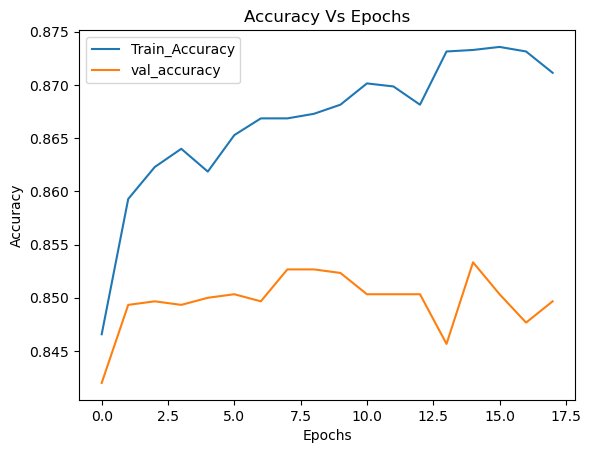

In [45]:
plt.plot(history.history['accuracy'],label = 'Train_Accuracy')
plt.plot(history.history['val_accuracy'],label = 'val_accuracy')
plt.title('Accuracy Vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

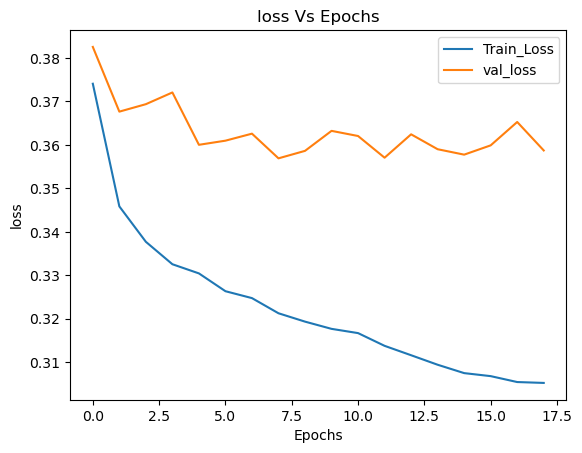

In [46]:
plt.plot(history.history['loss'],label = 'Train_Loss')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.title('loss Vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [47]:
model.save('model.h5')

In [50]:
import pickle

In [ ]:
with opem 